# Summary
This is a copy of MLmodel8postprocess.
This code is written to use and integrate the models that were learned in `MLmodel8.ipynb` and `MLmodel8_timestep.ipynb` and also plot some of the scaling laws that we are interested in. 

# To do
We need to seperate the snapshot learning and time step learning first and then try to integrate them together to plot the scaling laws.
## Snapshot Learning:
* load the data (done)
* load the model (done)
* plot the invariant measure (done)
* implement the code for N_m!=30 (done)
* timestep (done for N_m=30)
* timestep (for N_m!30) (done)
* plot the scaling laws
* saving figures
* calculate the time it takes to run the simulation


# Snapshot Learning

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv,Find_T_X_tau_without_p_input
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 
from scipy import integrate


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
Area=320e3*50e3
mu=30e9
V_thresh=(5e-8)
findscaling=1
t_yr=60*60*24*365
Nx=256
Nz=32
L_thresh=1e3
L=320e3
L_fault=L
W=50e3
x_ox=np.linspace(-L/2,L/2,Nx)
z_ox=np.linspace(0,W,Nz)

In [10]:
def FindMwupdated(V_full,t_full,V_thresh):
    flag=0
    V_max=np.max(V_full,axis=(1,2))
    Mw=np.array([])
    T1=np.array([]) # it is the time of when the earthquakes nucleate
    T2=np.array([]) # it is the time of when the earthquake stops
    PotRate=np.sum(V_full,axis=(1,2))*Area/Nx/Nz

    for i in range(V_max.size):
        
        if flag==0 and V_max[i]>V_thresh: # an event has started
            flag=1
            index1=i
            T1=np.append(T1,t_full[i])
        if flag==1 and V_max[i]<V_thresh: # the event has stopped
            flag=0
            index2=i
            IntPotRate=integrate.cumtrapz(PotRate[index1:index2+1],t_full[index1:index2+1])
            Integration=IntPotRate[-1]
            M0=Integration*mu
            Mw=np.append(Mw,(2/3)*np.log10(M0)-6)
            T2=np.append(T2,t_full[i])
    return Mw,T1,T2


In [11]:
# Loading POD modes
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyonV.npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']

data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyontheta.npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']


In [30]:
# Loading the data from the simulation
# Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/"
Tf = 250 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
N_m_theta=20 # number of modes that they have considered
N_m_load=30
coeff=2 # How the inital conditions are from the chaotic attractor
N_cut=2000
filter_ratio=0.4 # removing 40 percent of the data
# loading time series:
X_full=np.empty((1,N_m_load*2))

phi=U_v[:,:N_m_load]    # This contains the eigen mode for velocity
V_max_QDYN=np.empty((1,1))
Y_full=np.empty((1,1))
Mws=np.array([])
T1s=np.array([])
T2s=np.array([])
Mws_v2=np.array([])
T1s_v2=np.array([])
T2s_v2=np.array([])
rectangles_all=np.array([])
# The pick in the tail of the pdf is for one of the samples in the range 55 to 60
for number in range(100):
    data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/Dataset2/SampleSimulation_Tf"+str(Tf)+"Nt="+str(Nt)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data_smaple=np.load(data_dir)
    V_ox=data_smaple['array1']
    theta_ox=data_smaple['array2']
    t_ox=data_smaple['array3']
    # We work we log10 of V_ox:
    t=t_ox[:,0,0].reshape(-1,1)
    Start_index=int(V_ox.shape[0]*filter_ratio)
    if findscaling==1:
        Mw,T1,T2=FindMwupdated(V_ox[Start_index:,:,:],t_ox[Start_index:,0,0],V_thresh)
        Mws=np.append(Mws,Mw)
        T1s=np.append(T1s,T1)
        T2s=np.append(T2s,T2)
        TimeStarts,TimeEnds,rectangles,Mags=Find_T_X_tau_without_p_input(V_ox,t_ox,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)

        Mws_v2=np.append(Mws_v2,Mags)
        T1s_v2=np.append(T1s_v2,TimeStarts)
        T2s_v2=np.append(T2s_v2,TimeEnds)
        rectangles_all=np.append(rectangles_all,rectangles)
    dt=t[1:]-t[:-1]
    dt=np.log10(dt)

    V_ox=np.log10(V_ox)
    theta_ox=np.log10(theta_ox)

    V_max_onesimulation=np.max(V_ox,axis=(1,2))

    A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
    A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
    A=np.concatenate((A_v,A_theta),axis=1)
    
    X_onesimulation=A[Start_index:-1,:] # with removig the first 20 percent of the data to remove the transient
    Y_onesimulation=dt[Start_index:]
    V_max_onesimulation=V_max_onesimulation[Start_index:]
    X_full=np.append(X_full,X_onesimulation,axis=0)
    Y_full=np.append(Y_full,Y_onesimulation,axis=0)

    print("number is " +str(number)+ " size of data in this simulation is " +str(X_onesimulation.shape[0])+" total size is " + str(X_full.shape[0]))
    V_max_QDYN=np.append(V_max_QDYN,V_max_onesimulation[:-1])


V_max_QDYN=V_max_QDYN[1:]
X_full=X_full[1:,:]
Y_full=Y_full[1:,:]

(9799, 256)
(9799, 256)
0
688
(9799, 256)
(9799, 256)
885
896
(9799, 256)
(9799, 256)
988
1022
(9799, 256)
(9799, 256)
1088
1104
(9799, 256)
(9799, 256)
1213
1258
(9799, 256)
(9799, 256)
1425
1568
(9799, 256)
(9799, 256)
1616
1623
(9799, 256)
(9799, 256)
31.42709078137874
(9799, 256)
(9799, 256)
1623
1627
(9799, 256)
(9799, 256)
31.494456233482055
(9799, 256)
(9799, 256)
1727
1732
(9799, 256)
(9799, 256)
1822
1889
(9799, 256)
(9799, 256)
1927
1973
(9799, 256)
(9799, 256)
40.995555755878996
(9799, 256)
(9799, 256)
1971
2090
(9799, 256)
(9799, 256)
41.10073727421994
(9799, 256)
(9799, 256)
2142
2187
(9799, 256)
(9799, 256)
2264
2370
(9799, 256)
(9799, 256)
2413
2443
(9799, 256)
(9799, 256)
2517
2544
(9799, 256)
(9799, 256)
2724
2947
(9799, 256)
(9799, 256)
2991
3025
(9799, 256)
(9799, 256)
3026
3077
(9799, 256)
(9799, 256)
3229
3321
(9799, 256)
(9799, 256)
3388
3429
(9799, 256)
(9799, 256)
3536
3619
(9799, 256)
(9799, 256)
3721
3796
(9799, 256)
(9799, 256)
3833
3872
(9799, 256)
(9799, 25

In [31]:
number

99

In [8]:
print(T2s.shape)
print(T1s.shape)
print(Mws.shape)
print(T2s_v2.shape)
print(T1s_v2.shape)
print(Mws_v2.shape)

(433,)
(434,)
(433,)
(692,)
(692,)
(692,)


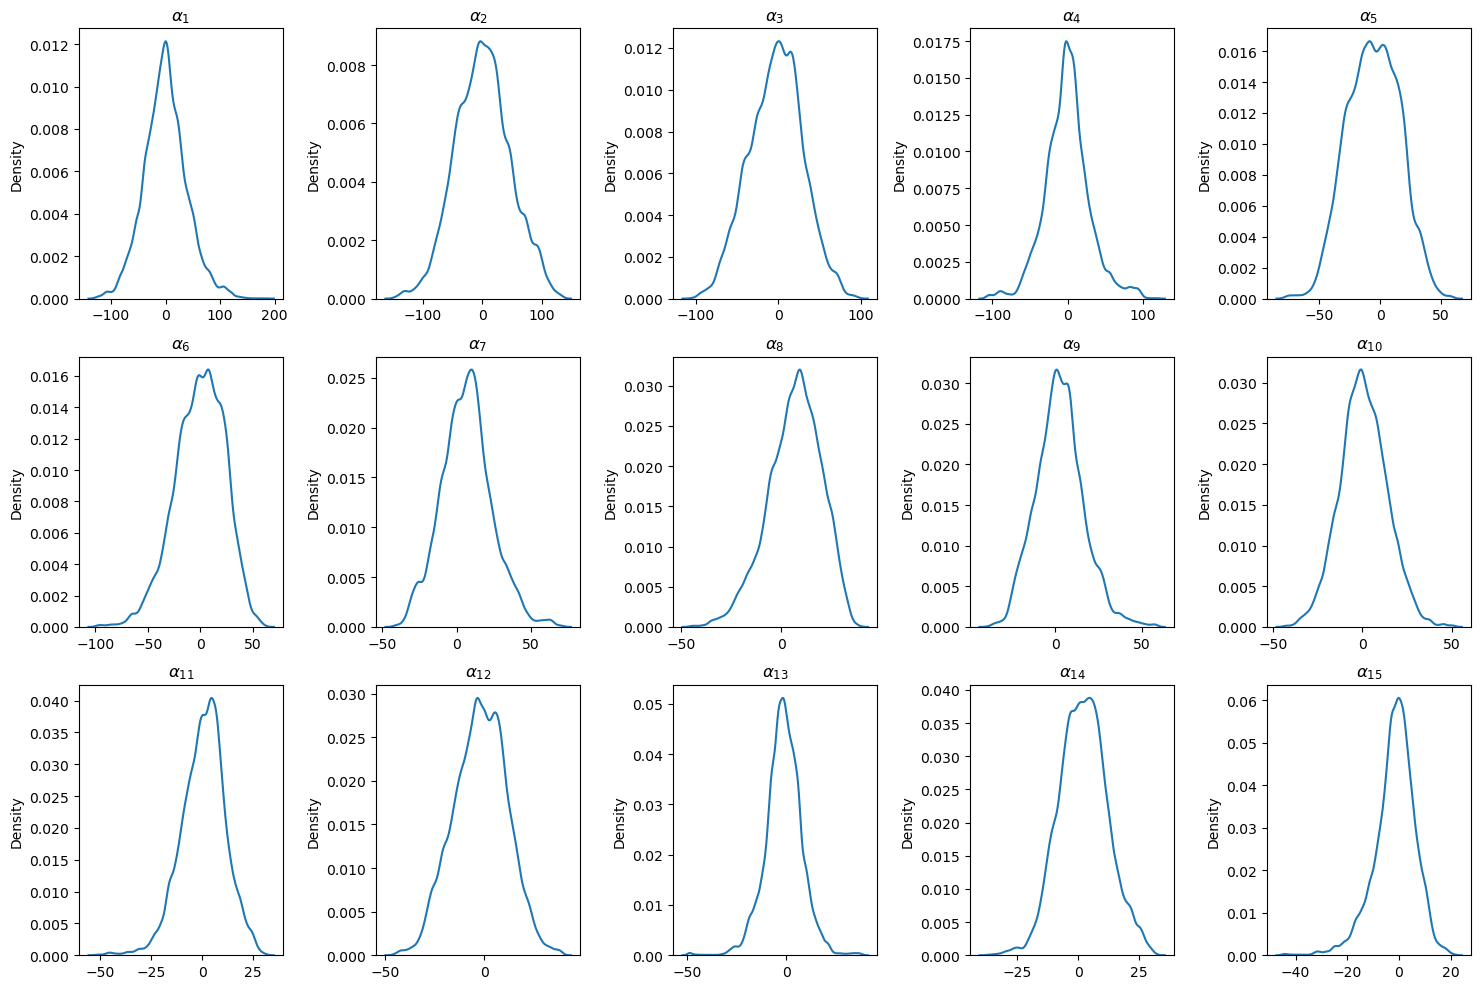

In [9]:
# Create a figure and axis objects
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(15):
    sns.kdeplot(X_full[:,i], ax=axs[i])
    axs[i].set_title(r'$\alpha_{{{}}}$'.format(i+1))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
# %% Defining model
class Forwardmap(nn.Module):
    def __init__(self,N_m):
        super().__init__()
        self.hidden1=nn.Linear(N_m,2*N_m)
        self.act1=nn.Tanh()
        self.hidden2=nn.Linear(2*N_m,4*N_m)
        self.act2=nn.Tanh()
        self.hidden3=nn.Linear(4*N_m,4*N_m)
        self.act3=nn.Tanh()
        self.hidden4=nn.Linear(4*N_m,2*N_m)
        self.act4=nn.Tanh()
        self.output=nn.Linear(2*N_m,N_m)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=(self.output(x))
        return x
    
version=2024.11
model=Forwardmap(N_m_v+N_m_theta)
model.load_state_dict(torch.load( "/central/groups/astuart/hkaveh/Data/LearnROM/ROM_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+".pt"))
model.eval()


In [ ]:
# Running the ML model for a long time
# remember your input is scaled and the output is scaled too.
# For now, I am use the output file but later you should save the max_X and max_y
# max_X=928.8324574287669
# max_y=26.351065203181317 # for version 0
# max_X=928.8324574287669
# max_y=13.638293616464068



max_X=657.090180396257
max_y=28.19128123215918

xk_v_0=X_full[-1,:N_m_v]
xk_theta_0=X_full[-1,N_m_load:N_m_load+N_m_theta]
xk=np.append(xk_v_0,xk_theta_0).reshape(1,N_m_v+N_m_theta)/max_X # We use the scaled coordinates

# xk=X_full[-1,:].reshape(1,N_m_v+N_m_theta)/max_X # We use the scaled coordinates
xk=torch.tensor(xk, dtype=torch.float32)
xk.to(device)

forecast30=xk.detach().numpy().reshape(N_m_v+N_m_theta,1)
# set the device for forecast30 to device
# forecast30.to(device)


for index in range(10*N_cut):
    ykp1=(model(xk))*(max_y/max_X)
    xkp1=ykp1+xk
    numpy_vector = xkp1.detach().numpy().reshape(N_m_v+N_m_theta,1)
    forecast30 = np.hstack([forecast30, numpy_vector])
    xk=xkp1

In [ ]:
xk.shape

In [ ]:
plt.plot(forecast30[0,:])
plt.plot(forecast30[1,:])
plt.plot(forecast30[-1,:])

In [ ]:
# Checking the invariant measure in the pytorch model

fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(15):
    sns.kdeplot(forecast30[i,:]*max_X, ax=axs[i],label='ROM n='+str(N_m_theta+N_m_v))
    sns.kdeplot(X_full[:, i], ax=axs[i],label='QDYN')
    axs[i].set_title(r'$\alpha_{{{}}}$'.format(i+1))
    axs[i].legend()


# Adjust layout and show plot
plt.tight_layout()
plt.show()



Writing the code for different models

In [ ]:
list_Nv=np.array([20,25,30])

list_Ntheta=np.array([20,25,30])
# max_X_list=np.array([928.8324574287669, 928.8324574287669,928.8324574287669])    # For version 0
max_X_list=np.array([657.090180396257, 657.090180396257,698.3903391568679])    # For version 2024.11
#max_y_list=np.array([26.351065203181317,26.351065203181317,26.351065203181317]) # For version 0
#max_y_list=np.array([13.638293616464068,13.638293616464068,13.638293616464068])  # For version 96
max_y_list=np.array([28.19128123215918,28.19128123215918,25.87581902121011])  # For version 2024.11


version=2024.11
N_it=25000
#N_it=1000
forecasts=[]
X_MLs=[]
for i in range(list_Nv.size):
    # loading the model
    model=Forwardmap(list_Nv[i]+list_Ntheta[i])
    model.load_state_dict(torch.load( "/central/groups/astuart/hkaveh/Data/LearnROM/ROM_POD_separate_onV_theta"+str(version)+"N_m_v"+str(list_Nv[i])+"N_m_theta"+str(list_Ntheta[i])+".pt"))
    model.eval()
    # making an initial condition
    index_delete=np.array([])
    if list_Nv[i]<N_m_load:
        index_delete=np.append(index_delete,np.arange(list_Nv[i],N_m_load))
    if list_Ntheta[i]<N_m_load:
        index_delete=np.append(index_delete,np.arange(N_m_load+list_Ntheta[i],2*N_m_load))
    xk=X_full[-1,:].reshape(1,N_m_load+N_m_load)/max_X_list[i] # We use the scaled coordinates
        #removing the extra modes
    index_delete = index_delete.astype(int)
    xk=np.delete(xk,index_delete)
    xk=torch.tensor(xk, dtype=torch.float32)
    xk.to(device)
    forecast=xk.detach().numpy().reshape(list_Nv[i]+list_Ntheta[i],1)
    for index in range(N_it):
        ykp1=(model(xk))*(max_y_list[i]/max_X_list[i])
        xkp1=ykp1+xk
        numpy_vector = xkp1.detach().numpy().reshape(list_Nv[i]+list_Ntheta[i],1)
        forecast = np.hstack([forecast, numpy_vector])
        xk=xkp1 
    forecasts.append(forecast)
    X_MLs.append(forecast.T*max_X_list[i])



In [ ]:
# Checking the invariant measure in the pytorch model
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(4,3, figsize=(8, 10))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 7})


# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(12):
    sns.kdeplot(forecasts[0][i,:]*max_X_list[0], ax=axs[i],label='ROM (n=40)')
    #sns.kdeplot(forecasts[1][i,:]*max_X_list[1], ax=axs[i],label='ROM (n=50)')
    sns.kdeplot(forecasts[2][i,:]*max_X_list[2], ax=axs[i],label='ROM (n=60)')
    sns.kdeplot(X_full[:, i], ax=axs[i],label='PDE',color='black')
    axs[i].set_title(r'$\alpha^v_{{{}}}$'.format(i+1))
    axs[i].legend(frameon=False)




# Adjust layout and show plot
plt.tight_layout()

plt.show()
# saving the figure in the central group directory
fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/invariant_measure_v"+".pdf", bbox_inches='tight')

In [ ]:
# Checking the invariant measure in the pytorch model
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(4,3, figsize=(8, 10))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 7})

axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(12):
    sns.kdeplot(forecasts[0][i+list_Nv[0],:]*max_X_list[0], ax=axs[i],label='ROM (n=40)')
    #sns.kdeplot(forecasts[1][i+list_Nv[1],:]*max_X_list[1], ax=axs[i],label='ROM (n=50)')
    sns.kdeplot(forecasts[2][i+list_Nv[2],:]*max_X_list[2], ax=axs[i],label='ROM (n=60)')
    sns.kdeplot(X_full[:, i+N_m_load], ax=axs[i],label='PDE',color='black')
    axs[i].set_title(r'$\alpha^\theta_{{{}}}$'.format(i+1))
    axs[i].legend(frameon=False)
    print(i+list_Nv[0])

# Adjust layout and show plot
plt.tight_layout()
plt.show()
fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/invariant_measure_theta"+".pdf", bbox_inches='tight')

# Time Step Learning

In [ ]:
# The reduced order model for v is already loaded
# lets load the model for dt
# Loading the pytorch ML model
# we had saved the model with the following code:
version=2024.11
#torch.save(model.state_dict(), "/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+".pt")# now we want to load it
# lets code the forward model
# %% Defining model
class Forwardmapdt(nn.Module):
    def __init__(self,N_m):
        super().__init__()
        self.hidden1=nn.Linear(N_m+1,2*N_m)
        self.act1=nn.Tanh()
        self.hidden2=nn.Linear(2*N_m,4*N_m)
        self.act2=nn.Tanh()
        self.hidden3=nn.Linear(4*N_m,4*N_m)
        self.act3=nn.Tanh()
        self.hidden4=nn.Linear(4*N_m,2*N_m)
        self.act4=nn.Tanh()
        self.output=nn.Linear(2*N_m,1)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=(self.output(x))
        return x
    


In [ ]:
def find_logvmax(alpha,phi_v):
    v=np.dot(phi_v,alpha)[:, np.newaxis]+q_bar_v # v and theta
    logvmax=np.max(v)
    return logvmax

In [ ]:
# Now, lets scale the X_full and concatinate logvmax_reducedmodel into the input data in order to use modeldt
max_X_dt=657.0901803962595 # these are the same for different list_Nv[i]
max_Y_dt=7.330702809730826 # these are the same for different list_Nv[i]


In [ ]:
logvmax_reducedmodels=np.zeros((X_full.shape[0],3))
strings=['40','50','60']
# initializing a figure with adjusting the rcParams

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 1, figsize=(3.7, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})


for i in [0,2]:
    print(i)
    index_delete=np.array([])
    if list_Nv[i]<N_m_load:
        index_delete=np.append(index_delete,np.arange(list_Nv[i],N_m_load))
    index_delete = index_delete.astype(int)
    print(index_delete)
    # removing colmns from X_full and phi
    X_full_removed=np.delete(X_full,index_delete,axis=1) # this still contains theta
    phi_removed=np.delete(phi,index_delete,axis=1)
    
    logvmax_reducedmodel=np.zeros((X_full_removed.shape[0],1))
    for j in range(X_full_removed.shape[0]):
        logvmax_reducedmodels[j,i]=find_logvmax(X_full_removed[j,:list_Nv[i]],phi_removed)   
    X_full_scaled=X_full_removed[:,:list_Nv[i]]/max_X_dt
    X_full_scaled = np.concatenate((X_full_scaled, logvmax_reducedmodels[:,i].reshape(X_full_scaled.shape[0],1)), axis=1)
    Y_full_scaled=Y_full/max_Y_dt
    X_cut=X_full_scaled[-N_cut:,:]
    Y_cut=Y_full_scaled[-N_cut:,:]
    
    if i==0:
        axs.plot(Y_cut[:,0]*max_Y_dt,label='True',linewidth=3) 
    X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
    index=np.linspace(1,N_cut-1,N_cut-1)
    modeldt=Forwardmapdt(list_Nv[i])
    modeldt.load_state_dict( torch.load("/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(list_Nv[i])+".pt"))
    modeldt.eval()
    X_cut_tensor.to(device)
    Pred=modeldt(X_cut_tensor)
    axs.plot(Pred.detach().numpy()[:,0]*max_Y_dt,label=' n='+str(strings[i]))
axs.set_xlabel('iteration')
axs.set_ylabel(r'$\log_{10}dt$')
axs.legend(frameon=False)
# saving the figure in the central group directory
fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/draft_dt"+".pdf", bbox_inches='tight')

    
    
    

# Plot the scaling laws

In [ ]:
plt.plot(t_ox[Start_index:,0,0]/t_yr,V_max_onesimulation)
for i in range(TimeStarts.size):
    plt.axvline(x=TimeStarts[i]/t_yr,color='r')
    plt.axvline(x=TimeEnds[i]/t_yr,color='b')
plt.axhline(y=np.log10(V_thresh),color='g')
plt.xlim([215,225])

In [ ]:
# plt.plot(10**(1.5*(Mws+6)),T2s-T1s,'o',label='QDYN')
# plt.xscale('log')
# plt.yscale('log')
# plt.plot(10**(1.5*(Mws_v2+6)),T2s_v2-T1s_v2,'o',label='QDYN updated method to find magnitude')  
# plt.legend()
# plt.title('Moment Duration Scaling Law')
# plt.xlabel(r"$\int_{t_1}^{t_2} \mu \dot{P} dt$")
# plt.ylabel(r"duration (s)")

In [ ]:
# plotting the moment area scaling law
plt.figure()
Nrectangles=int(rectangles_all.size/4)
rectangles_all=np.reshape(rectangles_all,(Nrectangles,4))
Areas=W*(rectangles_all[:,3])*1000
plt.plot(10**(1.5*(Mws_v2+6)),Areas,'o',label='QDYN updated method to find magnitude')  
plt.title('Moment Area Scaling Law')
plt.xlabel(r"$\int_{t_1}^{t_2} \mu \dot{P} dt$")
plt.ylabel(r"Area ($m^2$)")
plt.xscale('log')
plt.yscale('log')

In [ ]:
logvmax_reducedmodels=np.zeros((N_it+1,3))
times=np.zeros((N_it+1,3))
# Finding the three dimensional velocities matrix from the ROM
# make a figure with two subplots:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

size=U_v.shape[0]
size_x=256
size_y=32
V_ox_ROMs=[]
t_ox_ROMs=[]
for i in range(1):
    # organize the input
    X_input_partial=X_MLs[i] # xinput without the vmax
    # finding vmax
    for j in range(N_it+1):
        logvmax_reducedmodels[j,i]=find_logvmax(X_input_partial[j,:list_Nv[i]],phi[:,:list_Nv[i]])    
    X_ML_scaled=X_input_partial[:,:list_Nv[i]]/max_X_dt
    X_ML_scaled = np.concatenate((X_ML_scaled, logvmax_reducedmodels[:,i].reshape(N_it+1,1)), axis=1)
    # load model:
    modeldt=Forwardmapdt(list_Nv[i])
    modeldt.load_state_dict( torch.load("/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(list_Nv[i])+".pt"))
    modeldt.eval()
    X_ML_scaled_tensor = torch.tensor(X_ML_scaled, dtype=torch.float32)
    X_ML_scaled_tensor.to(device)
    dt_ML=modeldt(X_ML_scaled_tensor)
    dt_ML_detach=dt_ML.detach().numpy()
    dt_ML_detach_scaled=dt_ML_detach*max_Y_dt
    dt_ML_realtime=10**dt_ML_detach_scaled
    time_ML=np.cumsum(dt_ML_realtime)
    times[:,i]=time_ML
    # plt.plot(dt_ML.detach().numpy(),label='Predicted')  
    time_ML=time_ML.reshape(-1,1,1) # adding three dimension to time_ML
    # 
    U_ROM=U_v[:,0:list_Nv[i]]
    
    V_ox_ROM=np.empty((N_it+1,size_y,size_x))
    t_ox_ROM=np.ones((N_it+1,size_y,size_x))
    #appending vmax
    vmax=[]
    for j in range(N_it+1):
        V_snapshot = U_ROM @ (forecasts[i][:list_Nv[i], j] * max_X_list[i]) + q_bar_v.reshape(size,)
        V_snapshot = V_snapshot[:size_x * size_y].reshape(size_y, size_x)
        vmax.append(np.max(V_snapshot))
        V_ox_ROM[j,:,:]=10**(V_snapshot)
        t_ox_ROM[j,:,:]=time_ML[j]*np.ones((size_y,size_x))
    V_ox_ROMs.append(V_ox_ROM)
    t_ox_ROMs.append(t_ox_ROM)
    TimeStarts_ML,TimeEnds_ML,rectangles_ML,Mags_ML=Find_T_X_tau_without_p_input(V_ox_ROM,t_ox_ROM,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
    axs[0].plot(10**(1.5*(Mags_ML+6)),TimeEnds_ML-TimeStarts_ML,'o',label='ROM with n='+str(strings[i]),alpha=0.2)
    Nrectangles_ML=int(rectangles_ML.size/4)
    rectangles_ML=np.reshape(rectangles_ML,(Nrectangles_ML,4))
    Areas_ML=W*(rectangles_ML[:,3])*1000
    axs[1].plot(10**(1.5*(Mags_ML+6)),Areas_ML,'o',label='ROM with n='+str(strings[i]),alpha=0.2)


axs[0].plot(10**(1.5*(Mws_v2+6)),T2s_v2-T1s_v2,'o',label='PDE',color='black',alpha=0.005)  
axs[1].plot(10**(1.5*(Mws_v2+6)),Areas,'o',label='PDE',color='black',alpha=0.005)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend(loc='upper left')
#axs[0].set_title('Moment Duration Scaling Law')
axs[0].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[0].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend(loc='upper left')
#axs[1].set_title('Moment Area Scaling Law')
axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[1].set_ylabel(r"$A_{event}$ ($m^2$)")
# plot a line with slope 1/3 in log log scale
x = np.linspace(10**(16),10**18,100)
y = 10**(1/3*np.log10(x*1e5)) 
y2= 10**(2/3*np.log10(x*1e-3))
axs[0].plot(x,y,color='black')
axs[1].plot(x,y2,color='black')

# adding text on the plot
axs[0].text(10**17,10**7,'$T \propto M^{1/3}$',rotation=20)
axs[1].text(10**17,10**9,'$A \propto M^{2/3}$',rotation=20)

for ax in axs:

    leg = ax.legend(loc='upper left')
    # Set legend handle alpha to 1 for each legend
    for lh in leg.legendHandles:
        lh.set_alpha(1)
plt.tight_layout()
#saving the figure in the central group directory
fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/scaling_lawsN=40"+".pdf", bbox_inches='tight')



In [ ]:
version

In [ ]:
logvmax_reducedmodels=np.zeros((N_it+1,3))
times=np.zeros((N_it+1,3))
# Finding the three dimensional velocities matrix from the ROM
# make a figure with two subplots:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

size=U_v.shape[0]
size_x=256
size_y=32
V_ox_ROMs=[]
t_ox_ROMs=[]
for i in range(1,2):
    # organize the input
    X_input_partial=X_MLs[i] # xinput without the vmax
    # finding vmax
    for j in range(N_it+1):
        logvmax_reducedmodels[j,i]=find_logvmax(X_input_partial[j,:list_Nv[i]],phi[:,:list_Nv[i]])    
    X_ML_scaled=X_input_partial[:,:list_Nv[i]]/max_X_dt
    X_ML_scaled = np.concatenate((X_ML_scaled, logvmax_reducedmodels[:,i].reshape(N_it+1,1)), axis=1)
    # load model:
    modeldt=Forwardmapdt(list_Nv[i])
    modeldt.load_state_dict( torch.load("/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(list_Nv[i])+".pt"))
    modeldt.eval()
    X_ML_scaled_tensor = torch.tensor(X_ML_scaled, dtype=torch.float32)
    X_ML_scaled_tensor.to(device)
    dt_ML=modeldt(X_ML_scaled_tensor)
    dt_ML_detach=dt_ML.detach().numpy()
    dt_ML_detach_scaled=dt_ML_detach*max_Y_dt
    dt_ML_realtime=10**dt_ML_detach_scaled
    time_ML=np.cumsum(dt_ML_realtime)
    times[:,i]=time_ML
    # plt.plot(dt_ML.detach().numpy(),label='Predicted')  
    time_ML=time_ML.reshape(-1,1,1) # adding three dimension to time_ML
    # 
    U_ROM=U_v[:,0:list_Nv[i]]
    
    V_ox_ROM=np.empty((N_it+1,size_y,size_x))
    t_ox_ROM=np.ones((N_it+1,size_y,size_x))
    #appending vmax
    vmax=[]
    for j in range(N_it+1):
        V_snapshot = U_ROM @ (forecasts[i][:list_Nv[i], j] * max_X_list[i]) + q_bar_v.reshape(size,)
        V_snapshot = V_snapshot[:size_x * size_y].reshape(size_y, size_x)
        vmax.append(np.max(V_snapshot))
        V_ox_ROM[j,:,:]=10**(V_snapshot)
        t_ox_ROM[j,:,:]=time_ML[j]*np.ones((size_y,size_x))
    V_ox_ROMs.append(V_ox_ROM)
    t_ox_ROMs.append(t_ox_ROM)
    TimeStarts_ML,TimeEnds_ML,rectangles_ML,Mags_ML=Find_T_X_tau_without_p_input(V_ox_ROM,t_ox_ROM,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
    axs[0].plot(10**(1.5*(Mags_ML+6)),TimeEnds_ML-TimeStarts_ML,'o',label='ROM with n='+str(strings[i]),alpha=0.2)
    Nrectangles_ML=int(rectangles_ML.size/4)
    rectangles_ML=np.reshape(rectangles_ML,(Nrectangles_ML,4))
    Areas_ML=W*(rectangles_ML[:,3])*1000
    axs[1].plot(10**(1.5*(Mags_ML+6)),Areas_ML,'o',label='ROM with n='+str(strings[i]),alpha=0.2)


axs[0].plot(10**(1.5*(Mws_v2+6)),T2s_v2-T1s_v2,'o',label='PDE',color='black',alpha=0.005)  
axs[1].plot(10**(1.5*(Mws_v2+6)),Areas,'o',label='PDE',color='black',alpha=0.005)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
#axs[0].set_title('Moment Duration Scaling Law')
axs[0].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[0].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()
#axs[1].set_title('Moment Area Scaling Law')
axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[1].set_ylabel(r"$A_{event}$ ($m^2$)")
x = np.linspace(10**(16),10**18,100)
y = 10**(1/3*np.log10(x*1e5)) 
y2= 10**(2/3*np.log10(x*1e-3))
axs[0].plot(x,y,color='black')
axs[1].plot(x,y2,color='black')

# adding text on the plot
axs[0].text(10**17,10**7,'$T \propto M^{1/3}$',rotation=20)
axs[1].text(10**17,10**9,'$A \propto M^{2/3}$',rotation=20)

for ax in axs:

    leg = ax.legend()
    # Set legend handle alpha to 1 for each legend
    for lh in leg.legendHandles:
        lh.set_alpha(1)
plt.tight_layout()
fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/scaling_lawsN=50"+".pdf", bbox_inches='tight')


In [ ]:
logvmax_reducedmodels=np.zeros((N_it+1,3))
times=np.zeros((N_it+1,3))
# Finding the three dimensional velocities matrix from the ROM
# make a figure with two subplots:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'text.usetex': True,  # If you want to use LaTeX for rendering text
})
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

plt.rcParams.update({'font.family': 'serif', 'font.serif': 'Times New Roman','font.size': 8})

size=U_v.shape[0]
size_x=256
size_y=32
V_ox_ROMs=[]
t_ox_ROMs=[]
for i in range(2,3):
    # organize the input
    X_input_partial=X_MLs[i] # xinput without the vmax
    # finding vmax
    for j in range(N_it+1):
        logvmax_reducedmodels[j,i]=find_logvmax(X_input_partial[j,:list_Nv[i]],phi[:,:list_Nv[i]])    
    X_ML_scaled=X_input_partial[:,:list_Nv[i]]/max_X_dt
    X_ML_scaled = np.concatenate((X_ML_scaled, logvmax_reducedmodels[:,i].reshape(N_it+1,1)), axis=1)
    # load model:
    modeldt=Forwardmapdt(list_Nv[i])
    modeldt.load_state_dict( torch.load("/central/groups/astuart/hkaveh/Data/LearnROM/ROMdt_POD_separate_onV_theta"+str(version)+"N_m_v"+str(list_Nv[i])+".pt"))
    modeldt.eval()
    X_ML_scaled_tensor = torch.tensor(X_ML_scaled, dtype=torch.float32)
    X_ML_scaled_tensor.to(device)
    dt_ML=modeldt(X_ML_scaled_tensor)
    dt_ML_detach=dt_ML.detach().numpy()
    dt_ML_detach_scaled=dt_ML_detach*max_Y_dt
    dt_ML_realtime=10**dt_ML_detach_scaled
    time_ML=np.cumsum(dt_ML_realtime)
    times[:,i]=time_ML
    # plt.plot(dt_ML.detach().numpy(),label='Predicted')  
    time_ML=time_ML.reshape(-1,1,1) # adding three dimension to time_ML
    # 
    U_ROM=U_v[:,0:list_Nv[i]]
    
    V_ox_ROM=np.empty((N_it+1,size_y,size_x))
    t_ox_ROM=np.ones((N_it+1,size_y,size_x))
    #appending vmax
    vmax=[]
    for j in range(N_it+1):
        V_snapshot = U_ROM @ (forecasts[i][:list_Nv[i], j] * max_X_list[i]) + q_bar_v.reshape(size,)
        V_snapshot = V_snapshot[:size_x * size_y].reshape(size_y, size_x)
        vmax.append(np.max(V_snapshot))
        V_ox_ROM[j,:,:]=10**(V_snapshot)
        t_ox_ROM[j,:,:]=time_ML[j]*np.ones((size_y,size_x))
    V_ox_ROMs.append(V_ox_ROM)
    t_ox_ROMs.append(t_ox_ROM)
    TimeStarts_ML,TimeEnds_ML,rectangles_ML,Mags_ML=Find_T_X_tau_without_p_input(V_ox_ROM,t_ox_ROM,V_thresh,L_thresh,t_yr,x_ox,z_ox,L_fault,mu)
    axs[0].plot(10**(1.5*(Mags_ML+6)),TimeEnds_ML-TimeStarts_ML,'o',label='ROM with n='+str(strings[i]),alpha=0.2)
    Nrectangles_ML=int(rectangles_ML.size/4)
    rectangles_ML=np.reshape(rectangles_ML,(Nrectangles_ML,4))
    Areas_ML=W*(rectangles_ML[:,3])*1000
    axs[1].plot(10**(1.5*(Mags_ML+6)),Areas_ML,'o',label='ROM with n='+str(strings[i]),alpha=0.2)


axs[0].plot(10**(1.5*(Mws_v2+6)),T2s_v2-T1s_v2,'o',label='PDE',color='black',alpha=0.005)  
axs[1].plot(10**(1.5*(Mws_v2+6)),Areas,'o',label='PDE',color='black',alpha=0.005)

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].legend()
#axs[0].set_title('Moment Duration Scaling Law')
axs[0].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[0].set_ylabel(r"$t_{end}-t_{start}$ $(s)$")

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].legend()
#axs[1].set_title('Moment Area Scaling Law')
axs[1].set_xlabel(r"$\mu \int_{t_{start}}^{t_{end}} \int_{A_{event}} v dz dt$")
axs[1].set_ylabel(r"$A_{event}$ ($m^2$)")

x = np.linspace(10**(16),10**18,100)
y = 10**(1/3*np.log10(x*1e5)) 
y2= 10**(2/3*np.log10(x*1e-3))
axs[0].plot(x,y,color='black')
axs[1].plot(x,y2,color='black')

# adding text on the plot
axs[0].text(10**17,10**7,'$T \propto M^{1/3}$',rotation=20)
axs[1].text(10**17,10**9,'$A \propto M^{2/3}$',rotation=20)

for ax in axs:

    leg = ax.legend()
    # Set legend handle alpha to 1 for each legend
    for lh in leg.legendHandles:
        lh.set_alpha(1)
plt.tight_layout()
fig.savefig("/central/groups/astuart/hkaveh/Figs/ROM/scaling_lawsN=60"+".pdf", bbox_inches='tight')
